In [2]:
import os
import cv2
from pathlib import Path
import random
import torch
import glob
from shutil import copyfile
import torch.nn as nn
import torchinfo
from torchinfo import summary

In [3]:
from engine import train
from data_preparation import split_data, walk_through_dir
from ResNet import ResNet50
from utils import save_model, eval_model, accuracy_fn, plot_loss_curves, get_device
from dataloaders import create_dataloaders

In [4]:
#Change disk directory
base_path = Path("G:/Dissertation/")
if(Path().cwd() != Path(r"G:\Dissertation")):
    os.chdir(base_path)

In [5]:
dataset_path = Path('dataset/')
data_dir = Path("split_10k/")
split_size = [0.8,0.1,0.1]

#split_data(dataset_path, data_dir, split_size, num_img_class=10000)

In [6]:
walk_through_dir(data_dir)

There are 3 directories and 0 frames in 'split_10k'.
There are 5 directories and 0 frames in 'split_10k\train'.
There are 0 directories and 8000 frames in 'split_10k\train\1_Very_Good'.
There are 0 directories and 8000 frames in 'split_10k\train\2_Good'.
There are 0 directories and 8000 frames in 'split_10k\train\3_Moderate'.
There are 0 directories and 8000 frames in 'split_10k\train\4_Poor'.
There are 0 directories and 8000 frames in 'split_10k\train\5_Very_Poor'.
There are 5 directories and 0 frames in 'split_10k\validation'.
There are 0 directories and 1000 frames in 'split_10k\validation\1_Very_Good'.
There are 0 directories and 1000 frames in 'split_10k\validation\2_Good'.
There are 0 directories and 1000 frames in 'split_10k\validation\3_Moderate'.
There are 0 directories and 1000 frames in 'split_10k\validation\4_Poor'.
There are 0 directories and 1000 frames in 'split_10k\validation\5_Very_Poor'.
There are 5 directories and 0 frames in 'split_10k\test'.
There are 0 directories

In [7]:
from torchvision import transforms
#Create transform (in this case for the ResNet images are resized to 224x224 and transformed into Tensors)
data_transform = transforms.Compose([
  # Resize our images to 64x64
  transforms.Resize(size=(224, 224)),
  # Flip the images randomly on the horizontal (just to make it as independent from the position of the pipeline)
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.RandomVerticalFlip(p=0.5),
  # Turn the image into a torch.Tensor
  transforms.ToTensor() 
])

In [8]:
torch.cuda.empty_cache()

In [9]:
!nvidia-smi

Fri Feb 17 18:47:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.01       Driver Version: 516.01       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   40C    P8     4W /  N/A |   2529MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [10]:
#Paths criados pelo split_data
train_dir = data_dir / Path('train/')
validation_dir = data_dir / Path('validation/')
test_dir = data_dir / Path('test/')

BATCH_SIZE = 32 

train_dataloader, validation_dataloader, test_dataloader, class_names, train_data, validation_data, test_data = create_dataloaders(train_dir = train_dir,
                                                                                                                                   test_dir = test_dir,
                                                                                                                                   validation_dir = validation_dir,
                                                                                                                                   transform = data_transform,
                                                                                                                                   batch_size = BATCH_SIZE)

In [11]:
# Set number of epochs
NUM_EPOCHS = 5

device = get_device()
model_2 = ResNet50().to(device)

# Setup loss function and optimizer 
loss_fn = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(params=model_2.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer() 

# Train model
model_results = train(model=model_2,
                    train_dataloader=train_dataloader,
                    validation_dataloader=validation_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=NUM_EPOCHS,
                    device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3664 | train_acc: 0.8529 | validation_loss: 0.2535 | validation_acc: 0.8895
Epoch: 2 | train_loss: 0.1813 | train_acc: 0.9308 | validation_loss: 0.1508 | validation_acc: 0.9405
Epoch: 3 | train_loss: 0.1022 | train_acc: 0.9651 | validation_loss: 0.1688 | validation_acc: 0.9277
Epoch: 4 | train_loss: 0.0521 | train_acc: 0.9846 | validation_loss: 0.1065 | validation_acc: 0.9592
Epoch: 5 | train_loss: 0.0265 | train_acc: 0.9933 | validation_loss: 0.0154 | validation_acc: 0.9974
Total training time: 3491.025 seconds


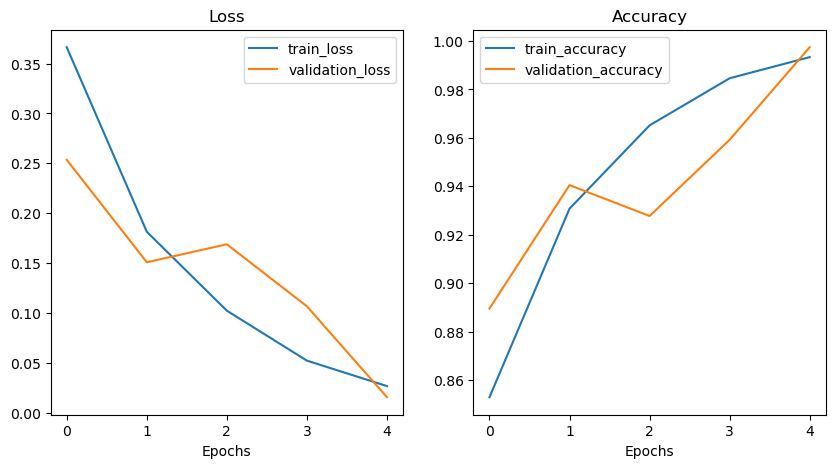

In [12]:
plot_loss_curves(model_results)

<function utils.plot_confusion_matrix(labels, pred_labels, classes)>

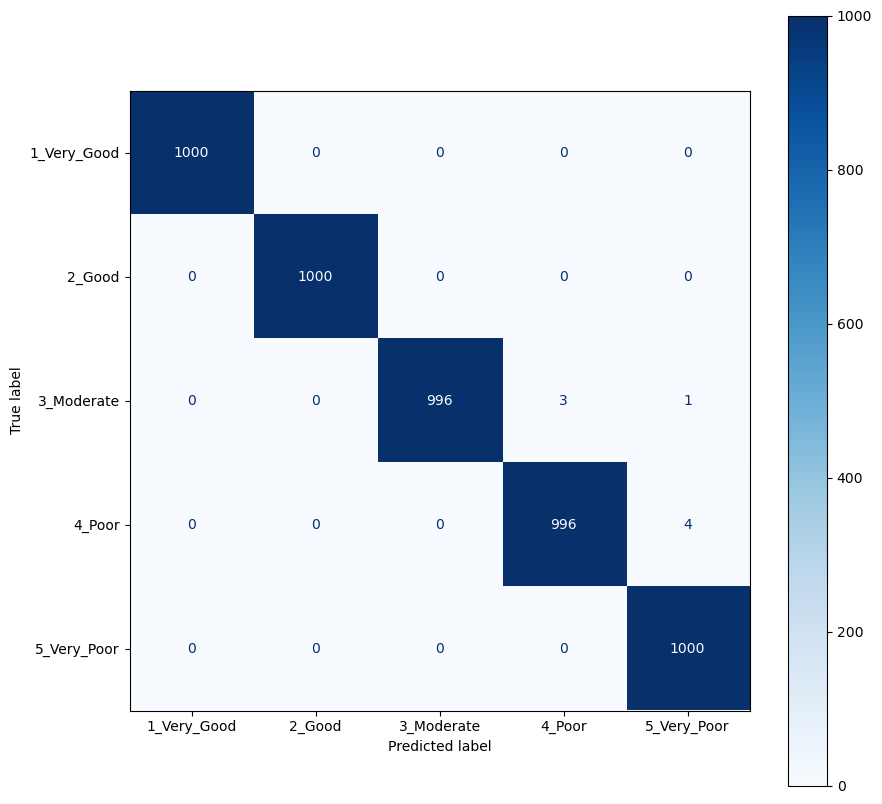

In [13]:
from utils import get_predictions, plot_confusion_matrix

classes = os.listdir(dataset_path)

images, labels, probs = get_predictions(model_2,test_dataloader,device)
pred_labels = torch.argmax(probs, 1) 
plot_confusion_matrix(labels, pred_labels, classes)
plot_confusion_matrix

In [14]:
models_path = Path('Models/')
model_name = 'ResNet50_10000_class_5_epoch.pth'

save_model(models_path, model_name, model_2)

model_path = models_path / model_name

loaded_model = ResNet50()
loaded_model.load_state_dict(torch.load(model_path))
loaded_model.to(device)

loaded_model_results = eval_model(  model=loaded_model,
                                    data_loader=validation_dataloader,
                                    loss_fn=loss_fn,
                                    accuracy_fn=accuracy_fn,
                                    device = device)
loaded_model_results

Saving the model to: Models\ResNet50_10000_class_5_epoch.pth


  0%|          | 0/157 [00:24<?, ?it/s]